<img src="https://raw.githubusercontent.com/EdsonAvelar/auc/master/molecular_banner.png" width=1900px height=400px />

# Predicting Molecular Properties

<h3> Can you measure the magnetic interactions between a pair of atoms? </h3>

This kernel is a combination of multiple kernels. The goal is to organize and explain the code to beginner competitors like me.<br>
This Kernels creates lots of new features and uses lightgbm as model

# Table of Contents:

**1. [Problem Definition](#id1)** <br>
**2. [Get the Data (Collect / Obtain)](#id2)** <br>
**3. [Load the Dataset](#id3)** <br>
**4. [Data Pre-processing](#id4)** <br>
**5. [Model](#id5)** <br>
**6. [Visualization and Analysis of Results](#id6)** <br>
**7. [Submittion](#id7)** <br>
**8. [References](#ref)** <br>

<a id="id1"></a> <br> 
# **1. Problem Definition:** 

This challenge aims to predict interactions between atoms. The main task is develop an algorithm that can predict the magnetic interaction between two atoms in a molecule (i.e., the scalar coupling constant)<br>

In this competition, you will be predicting the scalar_coupling_constant between atom pairs in molecules, given the two atom types (e.g., C and H), the coupling type (e.g., 2JHC), and any features you are able to create from the molecule structure (xyz) files.

**Data**
* **train.csv** - the training set, where the first column (molecule_name) is the name of the molecule where the coupling constant originates, the second (atom_index_0) and third column (atom_index_1) is the atom indices of the atom-pair creating the coupling and the fourth column (**scalar_coupling_constant**) is the scalar coupling constant that we want to be able to predict
* **test.csv** - the test set; same info as train, without the target variable
* **sample_submission.csv** - a sample submission file in the correct format
* **structures.csv** - this file contains the same information as the individual xyz structure files, but in a single file

**Additional Data**<br>
*NOTE: additional data is provided for the molecules in Train only!*
* **scalar_coupling_contributions.csv** - The scalar coupling constants in train.csv are a sum of four terms. The first column (**molecule_name**) are the name of the molecule, the second (**atom_index_0**) and third column (**atom_index_1**) are the atom indices of the atom-pair, the fourth column indicates the **type** of coupling, the fifth column (**fc**) is the Fermi Contact contribution, the sixth column (**sd**) is the Spin-dipolar contribution, the seventh column (**pso**) is the Paramagnetic spin-orbit contribution and the eighth column (**dso**) is the Diamagnetic spin-orbit contribution.



<a id="id2"></a> <br> 
# **2. Get the Data (Collect / Obtain):** 

## All imports used in this kernel

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v5
from IPython.display import HTML
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## All function used in this kernel

In [2]:
# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """
    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

<a id="id3"></a> <br> 
# **3. Load the Dataset** 

Let's load all necessary datasets

In [3]:

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub = pd.read_csv('../input/sample_submission.csv')
structures = pd.read_csv('../input/structures.csv')
scalar_coupling_contributions = pd.read_csv('../input/scalar_coupling_contributions.csv')

#Not used by now!
#magnetic_shielding_tensors = pd.read_csv('../input/magnetic_shielding_tensors.csv')
#dipole_moments = pd.read_csv('../input/dipole_moments.csv')
#potential_energy = pd.read_csv('../input/potential_energy.csv')
#mulliken_charges = pd.read_csv('../input/mulliken_charges.csv')

print('Train dataset shape is -> rows: {} cols:{}'.format(train.shape[0],train.shape[1]))
print('Test dataset shape is  -> rows: {} cols:{}'.format(test.shape[0],test.shape[1]))
print('Sub dataset shape is  -> rows: {} cols:{}'.format(sub.shape[0],sub.shape[1]))
print('Structures dataset shape is  -> rows: {} cols:{}'.format(structures.shape[0],structures.shape[1]))
print('Scalar_coupling_contributions dataset shape is  -> rows: {} cols:{}'.format(scalar_coupling_contributions.shape[0],
                                                                                   scalar_coupling_contributions.shape[1]))

Train dataset shape is -> rows: 4658147 cols:6
Test dataset shape is  -> rows: 2505542 cols:5
Sub dataset shape is  -> rows: 2505542 cols:2
Structures dataset shape is  -> rows: 2358657 cols:6
Scalar_coupling_contributions dataset shape is  -> rows: 4658147 cols:8


For an fast model/feature evaluation, get only 10% of dataset. Final submission must remove/coments this code

In [4]:
size = round(0.05*train.shape[0])
train = train[:size]
test = test[:size]
sub = sub[:size]
structures = structures[:size]
scalar_coupling_contributions = scalar_coupling_contributions[:size]

print('Train dataset shape is now rows: {} cols:{}'.format(train.shape[0],train.shape[1]))
print('Test dataset shape is now rows: {} cols:{}'.format(test.shape[0],test.shape[1]))
print('Sub dataset shape is now rows: {} cols:{}'.format(sub.shape[0],sub.shape[1]))
print('Structures dataset shape is now rows: {} cols:{}'.format(structures.shape[0],structures.shape[1]))
print('Scalar_coupling_contributions dataset shape is now rows: {} cols:{}'.format(scalar_coupling_contributions.shape[0],
                                                                                   scalar_coupling_contributions.shape[1]))


Train dataset shape is now rows: 232907 cols:6
Test dataset shape is now rows: 232907 cols:5
Sub dataset shape is now rows: 232907 cols:2
Structures dataset shape is now rows: 232907 cols:6
Scalar_coupling_contributions dataset shape is now rows: 232907 cols:8


The importante things to know is that the scalar coupling constants in train.csv are a sum of four terms. 
```
* fc is the Fermi Contact contribution
* sd is the Spin-dipolar contribution
* pso is the Paramagnetic spin-orbit contribution
* dso is the Diamagnetic spin-orbit contribution. 
```
Let's merge this into train

In [5]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [6]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,83.022400000000005,0.254579,1.25862,0.272010
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,-11.034700000000001,0.352978,2.85839,-3.433600
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,-11.032500000000001,0.352944,2.85852,-3.433870
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,-11.031900000000000,0.352934,2.85855,-3.433930
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,83.022199999999998,0.254585,1.25861,0.272013
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.254099999999999,-11.031700000000001,0.352932,2.85856,-3.433950
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.254799999999999,-11.032400000000001,0.352943,2.85853,-3.433870
7,7,dsgdb9nsd_000001,3,0,1JHC,84.809299999999993,83.024100000000004,0.254634,1.25856,0.272012
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.254300000000001,-11.031900000000000,0.352943,2.85856,-3.433930
9,9,dsgdb9nsd_000001,4,0,1JHC,84.809500000000000,83.024299999999997,0.254628,1.25856,0.272012


In [7]:
test.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC
5,4658152,dsgdb9nsd_000015,3,0,1JHC
6,4658153,dsgdb9nsd_000015,3,2,3JHC
7,4658154,dsgdb9nsd_000015,3,4,2JHH
8,4658155,dsgdb9nsd_000015,3,5,2JHH
9,4658156,dsgdb9nsd_000015,4,0,1JHC


Based in others ideais we can:<br>

- train a model to predict `fc` feature;
- add this feature to train and test and train the same model to compare performance;
- train a better model;

<a id="id4"></a> <br> 
# **4. Data Pre-processing** 

## Feature generation

In [8]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    df = reduce_mem_usage(df)
    return df

train = create_features(train)
test = create_features(test)

good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type']

for f in ['atom_1', 'type_0', 'type']:
    if f in good_columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

Mem. usage decreased to 41.98 Mb (69.3% reduction)
Mem. usage decreased to 39.31 Mb (69.3% reduction)


In [9]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
y_fc = train['fc']
X_test = test[good_columns].copy()

#del train, test
#gc.collect()

<a id="id5"></a> <br> 
# **5. Model** 


In [10]:
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

## Create out of fold feature

In [11]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb_oof = train_model_regression(X=X, X_test=X_test, y=y_fc, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=1000)


Fold 1 started at Sat Jun 15 23:48:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.680003	valid_1's l1: 1.05949
[1000]	training's l1: 0.454984	valid_1's l1: 0.997662
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.454984	valid_1's l1: 0.997662
Fold 2 started at Sat Jun 15 23:49:10 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.69349	valid_1's l1: 1.06512
[1000]	training's l1: 0.460762	valid_1's l1: 1.00515
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.460762	valid_1's l1: 1.00515
Fold 3 started at Sat Jun 15 23:49:37 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.70793	valid_1's l1: 1.08021
[1000]	training's l1: 0.476549	valid_1's l1: 1.01568
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.476549	valid_1's l1: 1.01568
CV mean score: -0.0731, std: 0.0200.


In [12]:
X['oof_fc'] = result_dict_lgb_oof['oof']
X_test['oof_fc'] = result_dict_lgb_oof['prediction']

In [13]:
def create_bunch_of_features(dtrain,dtest,cat_features):
    n_new_features = 0
    train_objs_num = len(dtrain)
    df_merge = pd.concat(objs=[X, X_test], axis=0)
     
        
    for feature in cat_features:
            #Log Transform
            df_merge[feature+'_log'] = np.log (df_merge[feature])
            n_new_features = n_new_features +1



    dtrain = df_merge[:train_objs_num]
    dtest = df_merge[train_objs_num:]
    del df_merge
    gc.collect()
    print('Features Created: {} \nTotal Features {}'.format(n_new_features,len(dtrain.columns)))
    return dtrain,dtest

features = list(X.columns)
X, X_test = create_bunch_of_features(X,X_test,features)

Features Created: 52 
Total Features 104


In [14]:
good_columns = ['oof_fc_log',
 'oof_fc',
 'molecule_atom_index_0_dist_min',
 'molecule_dist_mean',
 'molecule_couples',
 'molecule_atom_index_0_dist_std',
 'molecule_atom_index_0_y_1_mean_div_log',
 'molecule_atom_index_0_dist_mean',
 'molecule_atom_index_0_dist_max',
 'molecule_atom_1_dist_mean',
 'molecule_dist_max',
 'y_0',
 'molecule_atom_index_0_z_1_std',
 'molecule_atom_1_dist_std_diff',
 'molecule_atom_index_0_x_1_std',
 'molecule_atom_index_0_y_1_std',
 'molecule_atom_index_1_dist_min',
 'molecule_atom_index_1_dist_std',
 'molecule_atom_index_0_y_1_mean_diff_log',
 'molecule_atom_index_1_dist_mean',
 'molecule_dist_min',
 'molecule_atom_index_1_dist_max',
 'molecule_type_dist_std_diff',
 'molecule_type_dist_max',
 'molecule_type_dist_mean_diff_log',
 'molecule_type_dist_min',
 'molecule_atom_index_0_y_1_max_diff',
 'molecule_atom_index_0_y_1_mean_div',
 'molecule_atom_index_0_y_1_mean_diff',
 'molecule_atom_index_0_dist_mean_diff_log',
 'molecule_type_0_dist_std_diff',
 'molecule_atom_index_1_dist_std_diff',
 'y_0_log',
 'molecule_atom_index_1_dist_mean_diff_log',
 'molecule_atom_index_0_dist_std_diff',
 'molecule_atom_1_dist_min_diff',
 'molecule_type_dist_mean_diff',
 'molecule_atom_index_0_dist_max_div',
 'molecule_atom_index_1_dist_min_diff',
 'atom_index_1',
 'molecule_atom_index_0_dist_std_div',
 'atom_1_couples_count',
 'molecule_atom_index_0_dist_mean_div',
 'atom_index_0',
 'molecule_atom_index_1_dist_std_div',
 'molecule_atom_index_0_dist_max_diff',
 'molecule_type_dist_mean_div',
 'molecule_atom_index_1_dist_max_div',
 'molecule_atom_index_1_dist_max_diff',
 'molecule_atom_index_0_x_1_std_log',
 'type']

X = X[good_columns].copy()
X_test = X_test[good_columns].copy()


## Model with oof feature

Fold 1 started at Sat Jun 15 23:52:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[34]	training's l1: 0.933016	valid_1's l1: 0.976541
Fold 2 started at Sat Jun 15 23:52:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's l1: 0.935225	valid_1's l1: 0.978225
Fold 3 started at Sat Jun 15 23:53:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[34]	training's l1: 0.920369	valid_1's l1: 0.992429
CV mean score: -0.1098, std: 0.0261.


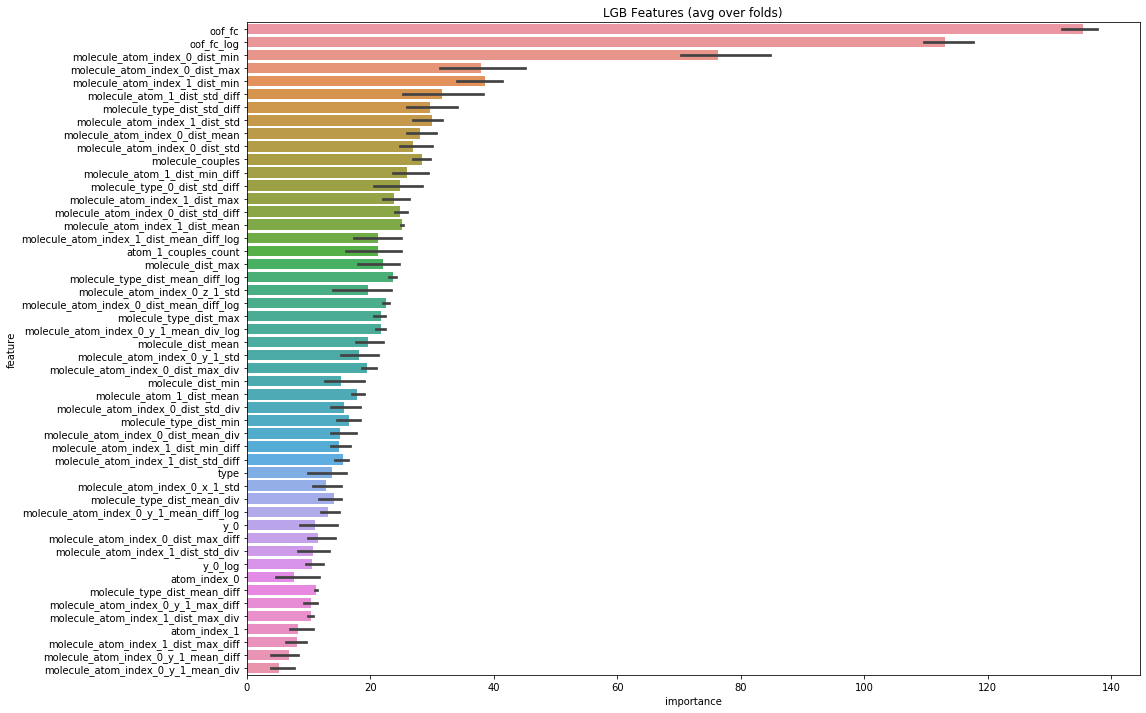

In [15]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=1000)

In [16]:
#Best Features?
feature_importance = result_dict_lgb2['feature_importance']
best_features = feature_importance[['feature','importance']].groupby(['feature']).mean().sort_values(
        by='importance',ascending=False).iloc[:50,0:0].index.tolist()
best_features

['oof_fc',
 'oof_fc_log',
 'molecule_atom_index_0_dist_min',
 'molecule_atom_index_1_dist_min',
 'molecule_atom_index_0_dist_max',
 'molecule_atom_1_dist_std_diff',
 'molecule_atom_index_1_dist_std',
 'molecule_type_dist_std_diff',
 'molecule_couples',
 'molecule_atom_index_0_dist_mean',
 'molecule_atom_index_0_dist_std',
 'molecule_atom_1_dist_min_diff',
 'molecule_atom_index_1_dist_mean',
 'molecule_type_0_dist_std_diff',
 'molecule_atom_index_0_dist_std_diff',
 'molecule_atom_index_1_dist_max',
 'molecule_type_dist_mean_diff_log',
 'molecule_atom_index_0_dist_mean_diff_log',
 'molecule_dist_max',
 'molecule_atom_index_0_y_1_mean_div_log',
 'molecule_type_dist_max',
 'molecule_atom_index_1_dist_mean_diff_log',
 'atom_1_couples_count',
 'molecule_dist_mean',
 'molecule_atom_index_0_z_1_std',
 'molecule_atom_index_0_dist_max_div',
 'molecule_atom_index_0_y_1_std',
 'molecule_atom_1_dist_mean',
 'molecule_type_dist_min',
 'molecule_atom_index_0_dist_std_div',
 'molecule_atom_index_1_dis

<a id="id6"></a> <br> 
# **6. Visualization and Analysis of Results** 

Fold 1 started at Sat Jun 15 23:53:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[26]	training's l1: 0.938063	valid_1's l1: 0.978798
Fold 2 started at Sat Jun 15 23:53:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[25]	training's l1: 0.938241	valid_1's l1: 0.98173
Fold 3 started at Sat Jun 15 23:53:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[25]	training's l1: 0.926871	valid_1's l1: 0.992168
CV mean score: -0.1058, std: 0.0244.


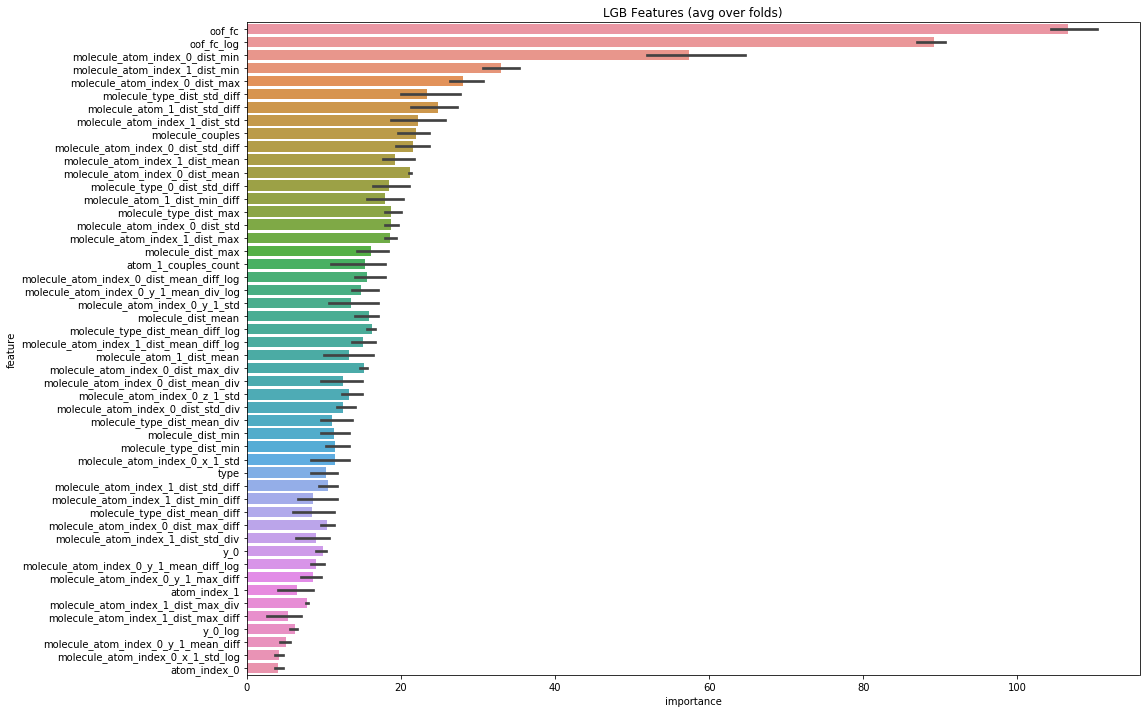

In [17]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.25,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=1000)

## Training models for each type

In [18]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb3 = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=3000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb3['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb3['prediction']
    


Training of type 0
Fold 1 started at Sat Jun 15 23:54:10 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.451223	valid_1's l1: 1.79196
[1000]	training's l1: 0.151704	valid_1's l1: 1.77335
[1500]	training's l1: 0.0582321	valid_1's l1: 1.76842
[2000]	training's l1: 0.0239155	valid_1's l1: 1.76693
[2500]	training's l1: 0.009549	valid_1's l1: 1.76637
[3000]	training's l1: 0.00422349	valid_1's l1: 1.76613
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00422349	valid_1's l1: 1.76613
Fold 2 started at Sat Jun 15 23:54:36 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.464336	valid_1's l1: 1.80655
[1000]	training's l1: 0.153666	valid_1's l1: 1.78615
[1500]	training's l1: 0.0604282	valid_1's l1: 1.78089
[2000]	training's l1: 0.0242998	valid_1's l1: 1.77928
[2500]	training's l1: 0.00986965	valid_1's l1: 1.77854
[3000]	training's l1: 0.00432885	valid_1's l1: 1.7783
Did not meet early stop

CV mean score: -0.5271, std: 0.0105.
Training of type 5
Fold 1 started at Sat Jun 15 23:59:00 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.244841	valid_1's l1: 0.756837
[1000]	training's l1: 0.0954651	valid_1's l1: 0.744187
[1500]	training's l1: 0.042159	valid_1's l1: 0.740241
[2000]	training's l1: 0.0191773	valid_1's l1: 0.739098
[2500]	training's l1: 0.0089052	valid_1's l1: 0.738452
[3000]	training's l1: 0.00468097	valid_1's l1: 0.738202
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00468097	valid_1's l1: 0.738202
Fold 2 started at Sat Jun 15 23:59:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.256792	valid_1's l1: 0.763696
[1000]	training's l1: 0.103948	valid_1's l1: 0.748927
[1500]	training's l1: 0.0450769	valid_1's l1: 0.74436
[2000]	training's l1: 0.0203652	valid_1's l1: 0.742969
[2500]	training's l1: 0.00956025	valid_1's l1: 0.742437
[3000]	training's l1: 0.0050

<a id="id7"></a> <br> 
# **7. Submittion** 

In [19]:
#Deep model
sub['scalar_coupling_constant'] = result_dict_lgb2['prediction']
sub.to_csv('submission_deepmodel.csv', index=False)
sub.head()

#Training models for type
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('submission_type.csv', index=False)
sub.head()

,id,scalar_coupling_constant
0,4658147,12.685936179914533
1,4658148,195.614975239043673
2,4658149,6.080874953915045
3,4658150,194.990190359161147
4,4658151,6.609013473225004


<a id="ref"></a> <br> 
# **8. References** 

[1] OOF Model: https://www.kaggle.com/adarshchavakula/out-of-fold-oof-model-cross-validation<br>
[2] Using Meta Features: https://www.kaggle.com/artgor/using-meta-features-to-improve-model<br>
[3] Lot of Features: https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b